### Fully Automated Cardiac Shape Modeling

End-to-End automation of the Cardiac Atlas Project, from SSFP MRI to CIM Mesh. 

Steps:
1. View selection
     - Export Slice Info File
2. Short axis slice selection
3. End-diastole and end-systole selection
4. Landmark localization
5. Segmentation
6. Guide point extraction
     - Export guide point file

In [109]:
# view selection
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import ipywidgets as widgets
import pydicom
from tqdm import tqdm
import cv2
import shutil
import tensorflow as tf
import torch
import nnunet # directly imports local nnunet installation
from nnunet.inference.predict import predict_from_folder
import matplotlib.pyplot as plt
%matplotlib inline

import utils

import warnings
warnings.filterwarnings('ignore')

print('Python: {}'.format(sys.version))
print('Pydicom: {}'.format(pydicom.__version__))
print('TensorFlow: {}'.format(tf.__version__))
print('Torch: {}'.format(torch.__version__))

Python: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Pydicom: 2.3.0
TensorFlow: 2.6.2
Torch: 1.10.2


If your device has a gpu and the necessary software installed, tensorflow will be able to detect it and display it here. If not, the entire notebook can be run on the CPU, but will take a significantly longer amount of time, particularly if normalization and test time augmentations are utilized during landmark localization. 

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

### Step 1: View Selection

### View Classification Option 1: Automated Predictions

The automated view selection is designed to automatically identify and select MRI views that are relavent to cardiac modeling. The analysis is designed to be run over a directory containing one or multiple patient subdirectories. The code runs the analysis iteratively over each subdirectory.

If you would like to use manual labels, skip ahead to the option 2 for view classification below.

The suggested directory structures for each approach are shown below:

Run the analysis over each patient in a directory individually (i.e., analysis for patient 1, then analysis for patient 2.)

```bash
├── DATA
    ├── Patient1
    │   ├── 1.dcm
    │   ├── 2.dcm 
    │   ├── 3.dcm          
    │   └── ...   
    └── Patient2
        ├── 1.dcm
        ├── 2.dcm 
        ├── 3.dcm          
        └── ...          
```

#### ENTER USER SETTINGS
Change the settings below to match the desired patient and correct src, dst, and csv_path. 

In [67]:
# PARAMETERS for the analysis
patient = 'venus1'
src = "../data/raw/source_Venus/preop/" + patient          # PATH to the directory containing the desired DICOM files (str)
dst = "../data/processed/"                       # PATH to the output directory to save dicom files (only valid if save_dicoms = True) (str)

# view selection model
modelname = 'ResNet50'                            # The neural network to load and used (Options: VGG19, ResNet50, or Xception)
use_multiprocessing = False                       # Use multiprocessing to read header info (True or False)

# parameters for postprocessing/saving
csv_path = '../data/processed/{}/view_predictions.csv'.format(patient)   # PATH to save the generated csv file (only valide if create_csv = True) (str)
create_csv = True                                 # Save a .csv file with the series level view predictions (True or False)
save_files = True                                 # Save dicom files to new directory (dst) (True or False)
save_only_desired = False                         # Save only dicom files corresponding to desired views (True or False)
confidence_value = 0.5                            # Only save series if the confidence is > a certain value (set to 0 to save all desired series, regardless of confidence) (float 0-1.0)

if not os.path.exists(os.path.join(dst, patient)):
    os.mkdir(os.path.join(dst,patient))

In [70]:
import importlib
import viewselection
importlib.reload(viewselection)

<module 'viewselection' from 'E:\\CAP\\CAP-FullAutomation\\src\\viewselection.py'>

In [71]:
# import the view selection scripts
from viewselection import ViewSelection

# initialize the viewSelector class with appropriate settings
viewSelector = ViewSelection(
                            src,
                            dst,
                            modelname,
                            csv_path,
                            create_csv,
                            use_multiprocessing,
                            save_files,
                            save_only_desired,
                            confidence_value
                            )

# initiate the tensorflow model
viewSelector.load_tensorflow_model()

# make predictions for src directory
viewSelector.complete_view_prediction()

In [72]:
# the view predictions are saved to the specified csv_path file. We can load in this csv file and 
# see what views were predicted for each series in the raw MRI dump. 
selected = pd.read_csv(csv_path)

# filter dataframe to desired frames only if desired
# selected = selected[selected['Confidence'] > confidence_value]
# selected = selected[selected['Predicted View'].isin(['4CH', '3CH', 'SA', 'LVOT', 'RVOT', '2CH RT', '2CH LT'])]

# display dataframe
selected

,Patient ID,Series ID,Series Number,Frames,Frames Per Slice,Series Description,Predicted View,Confidence
0,venus1,1.3.12.2.1107.5.2.18.42170.2016012210345528466...,10,90,30,na,RVOT,0.43
1,venus1,1.3.12.2.1107.5.2.18.42170.2016012210301389215...,7,90,30,na,4CH,0.46
2,venus1,1.3.12.2.1107.5.2.18.42170.2016012210242189322...,6,390,30,na,SA,0.99
3,venus1,1.3.12.2.1107.5.2.18.42170.2016012210220983500...,5,90,30,na,4CH,0.67
4,venus1,1.3.12.2.1107.5.2.18.42170.2016012210194523750...,3,30,30,na,2CH LT,1.00
5,venus1,1.3.12.2.1107.5.2.18.42170.2016012210314396619...,8,90,30,na,SA,0.47


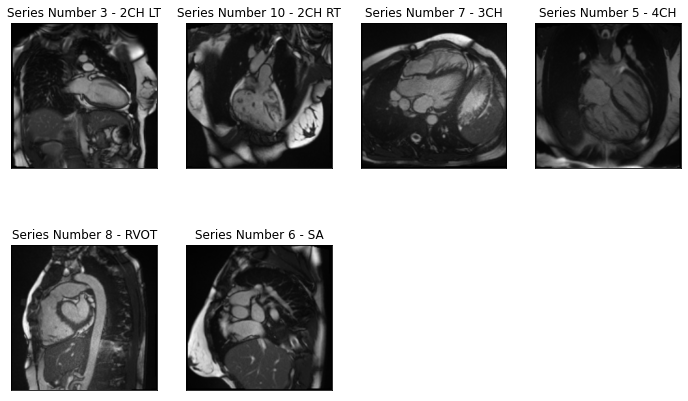

In [114]:
# display current series and classifications
utils.plot_view_classifications(dst, patient)

In [75]:
# generate widget to change selections
options = selected[['Series Number', 'Series Description', 'Predicted View', 'Confidence']]
items = [widgets.Checkbox(
    value=True,
    description='Series {} - {} - {} ({})'.format(row[0], row[1], row[2], row[3]),
    disabled=False,
    indent=False
) for i,row in options.iterrows()]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

print('Select Desired LAX and SA Series:')
grid

Select Desired LAX and SA Series:


GridBox(children=(Checkbox(value=True, description='Series 10 - na - RVOT (0.43)', indent=False), Checkbox(val…

In [78]:
# remove undesired series from processed directory
selected_series = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_series.append(int(items[i].description.split(' ')[1]))

print('Selected Series: ', selected_series)
for (root, subdirs, files) in os.walk(dst + patient):
    for file in files:
        if '.dcm' in file:
            dcm = pydicom.dcmread(os.path.join(root, file))
            if dcm.SeriesNumber not in selected_series:
                os.remove(os.path.join(root, file))
                #os.remove(root)
            else:
                pass
            
selected = selected[selected['Series Number'].isin(selected_series)]
print('Undesired files removed')

# record number of phases from SAX
num_phases = np.max([selected['Frames Per Slice']])
selected

Selected Series:  [10, 7, 6, 5, 3, 8]
Undesired files removed


,Patient ID,Series ID,Series Number,Frames,Frames Per Slice,Series Description,Predicted View,Confidence
0,venus1,1.3.12.2.1107.5.2.18.42170.2016012210345528466...,10,90,30,na,RVOT,0.43
1,venus1,1.3.12.2.1107.5.2.18.42170.2016012210301389215...,7,90,30,na,4CH,0.46
2,venus1,1.3.12.2.1107.5.2.18.42170.2016012210242189322...,6,390,30,na,SA,0.99
3,venus1,1.3.12.2.1107.5.2.18.42170.2016012210220983500...,5,90,30,na,4CH,0.67
4,venus1,1.3.12.2.1107.5.2.18.42170.2016012210194523750...,3,30,30,na,2CH LT,1.00
5,venus1,1.3.12.2.1107.5.2.18.42170.2016012210314396619...,8,90,30,na,SA,0.47


#### Useability Note

If necessary, the predicted views can be corrected using the code below (currently set to Raw NBConvert) in order to limit accidental changes. Enter the series number to change, the currently predicted view, and the actual (or correct) view. The code will copy the dicom files to the correct directory. 

#### Useability Note
The number of frames (or phases) per slice is automatically selected from the SAX stack. In some cases, the number of frames per slice may be different for different views (e.g., 30 frames per slice in the SAX, but only 20 frames per slice in the 4CH view). If this is the case, be sure to appropriately enter change the number of phases when performing landmark localization predictions below. 

Similarly, if a dicom file is missing, the number of frames per slice may be inaccurately low. For example, with one dicom missing, the number of frames might be set to 29, when it should actually be 30. Be sure to manually correct this error if it occurs. 

In [90]:
# fix directory structure if necessary for series that were incorrectly predicted
series_num = 8
pred_view = 'SA'
actual_view = 'RVOT'

if not os.path.isdir(os.path.join(dst, patient, actual_view)):
    os.mkdir(os.path.join(dst, patient, actual_view))

for file in os.listdir(os.path.join(dst, patient, pred_view)):
    if '.dcm' in file:
        dcm = pydicom.dcmread(os.path.join(dst, patient, pred_view, file))
        if dcm.SeriesNumber == series_num:
            shutil.move(os.path.join(dst, patient, pred_view, file), os.path.join(dst, patient, actual_view, file))

if len(os.listdir(os.path.join(dst, patient, pred_view))) == 0:
    os.rmdir(os.path.join(dst, patient, pred_view))
    
# update dataframe
index = selected.index[selected['Series Number'] == series_num].tolist()[0]
selected.at[index, 'Predicted View'] = actual_view
print('Done!')

Done!


In [91]:
# display updated dataframe
selected

,Patient ID,Series ID,Series Number,Frames,Frames Per Slice,Series Description,Predicted View,Confidence,ES Phase Prediction
0,venus1,1.3.12.2.1107.5.2.18.42170.2016012210345528466...,10,90,30,na,2CH RT,0.43,NaN
1,venus1,1.3.12.2.1107.5.2.18.42170.2016012210301389215...,7,90,30,na,3CH,0.46,NaN
2,venus1,1.3.12.2.1107.5.2.18.42170.2016012210242189322...,6,390,30,na,SA,0.99,11.0
3,venus1,1.3.12.2.1107.5.2.18.42170.2016012210220983500...,5,90,30,na,4CH,0.67,NaN
4,venus1,1.3.12.2.1107.5.2.18.42170.2016012210194523750...,3,30,30,na,2CH LT,1.00,NaN
5,venus1,1.3.12.2.1107.5.2.18.42170.2016012210314396619...,8,90,30,na,RVOT,0.47,11.0


### View Classification Option 2 - Manually Defined Views

If the the views have already been manually identified, we can use the following code to load the manual selections.

In [177]:
# path to xlsx of manual labels
manual_labels_path = '../reports/VenusSliceLabels.xlsx'

selected = utils.manual_view_classification(manual_labels_path, src, dst, patient)
selected

Manual labels loaded.
Found 0 source dicoms
Moving selected files...
Files moved! Building dataframe...


,Patient ID,Series ID,Series Number,Frames,Frames Per Slice,Series Description,Predicted View,Confidence
0,venus2,1.3.12.2.1107.5.2.30.26536.2016040615140053864...,22,40,30,na,2CH LT,1.0
1,venus2,1.3.12.2.1107.5.2.30.26536.2016040615233367527...,41,40,30,na,2CH RT,1.0
2,venus2,1.3.12.2.1107.5.2.30.26536.2016040615131075064...,21,40,30,na,3CH,1.0
3,venus2,1.3.12.2.1107.5.2.30.26536.2016040615123855218...,20,40,30,na,4CH,1.0
4,venus2,1.3.12.2.1107.5.2.30.26536.2016040615153649263...,24,40,30,na,RVOT,1.0
5,venus2,1.3.12.2.1107.5.2.30.26536.3001001604060916122...,79,440,30,na,SA,1.0


### Export 1 - Generate Slice Info File

Now that the views have been selected, we can export the slice info file for use with the BiV Modelling v2 code. The first code generates a pandas dataframe of this information (used throughout this notebook) while the second code exports it to a txt file. 

In [83]:
# generate slice info file for use with python CIM
sliceID = 0
out = []

# check for SA first
for subdir in os.listdir(os.path.join(dst, patient)):
    #if subdir == 'SA':
    if '.' not in subdir:
        stored_locs = []
        for file in os.listdir(os.path.join(dst, patient, subdir)):
            if '.dcm' in file:
                dcm = pydicom.dcmread(os.path.join(dst, patient, subdir, file))
                #if dcm.SliceLocation in good_locations:
                SOPInstanceUID = str(dcm.SOPInstanceUID)
                rows = dcm.Rows
                cols = dcm.Columns
                imagePositionPatient = dcm.ImagePositionPatient
                imageOrientationPatient = dcm.ImageOrientationPatient
                pixelSpacing = dcm.PixelSpacing

                if dcm.SliceLocation not in stored_locs:
                    row = [sliceID, file, subdir, dcm.SliceLocation, [rows, cols], imagePositionPatient, imageOrientationPatient, pixelSpacing]
                    out.append(row)
                    stored_locs.append(dcm.SliceLocation)
                    sliceID += 1

# generate dataframe
slice_info_df = pd.DataFrame(out, columns = ['Slice ID', 'File', 'View', 'Slice Location', 'Size', 'ImagePositionPatient', 'ImageOrientationPatient', 'Pixel Spacing'])

# generate mapping dictionary (short-axis slice to slice id) for future use
sa_df_sorted = slice_info_df[slice_info_df['View']=='SA'].sort_values('Slice Location', axis=0)
sa_mapping_dict = {}
for i, row in enumerate(sa_df_sorted.iterrows()):
    index, row = row[0], row[1]
    slice_id = row['Slice ID']
    sa_mapping_dict[slice_id] = i

# display slice info
slice_info_df

,Slice ID,File,View,Slice Location,Size,ImagePositionPatient,ImageOrientationPatient,Pixel Spacing
0,0,IM-0088-0001.dcm,2CH LT,27.286475,"[192, 156]","[-114.41131034358, 124.28840089107, 222.518150...","[0.78721423250071, -0.616679618723, 0, 0, 0, -1]","[1.875, 1.875]"
1,1,IM-0095-0001-0001.dcm,2CH RT,-43.090941,"[156, 192]","[-207.1333877571, 32.383458803949, 142.7090288...","[0.95755178969575, -5.1811205e-008, 0.28826128...","[1.7708333730698, 1.7708333730698]"
2,2,IM-0095-0001-0002.dcm,2CH RT,-48.090940,"[156, 192]","[-207.67027301864, 27.743295382318, 144.492460...","[0.95755178969575, -5.1811205e-008, 0.28826128...","[1.7708333730698, 1.7708333730698]"
3,3,IM-0095-0001-0003.dcm,2CH RT,-53.090942,"[156, 192]","[-208.20715780334, 23.103131960688, 146.275900...","[0.95755178969575, -5.1811205e-008, 0.28826128...","[1.7708333730698, 1.7708333730698]"
4,4,IM-0092-0001-0001.dcm,3CH,47.437889,"[156, 192]","[-102.50152817561, -94.624990843032, 151.00099...","[0.73887588846391, -2.6470641e-008, -0.6738415...","[1.5, 1.5]"
5,5,IM-0092-0001-0002.dcm,3CH,42.437887,"[156, 192]","[-105.86603728129, -94.361004255507, 147.31177...","[0.73887588846391, -2.6470641e-008, -0.6738415...","[1.5, 1.5]"
6,6,IM-0092-0001-0003.dcm,3CH,37.437889,"[156, 192]","[-109.23054567172, -94.097015760634, 143.62254...","[0.73887588846391, -2.6470641e-008, -0.6738415...","[1.5, 1.5]"
7,7,IM-0090-0001-0001.dcm,4CH,-15.846803,"[150, 192]","[-158.55254846941, 95.534108956586, 112.700866...","[0.99703901442821, 1.4384158e-008, 0.076897358...","[1.5, 1.5]"
8,8,IM-0090-0001-0002.dcm,4CH,-23.846802,"[150, 192]","[-158.97430235277, 89.710126717816, 118.169262...","[0.99703901442821, 1.4384158e-008, 0.076897358...","[1.5, 1.5]"
9,9,IM-0090-0001-0003.dcm,4CH,-31.846801,"[150, 192]","[-159.39605623613, 83.886145432721, 123.637657...","[0.99703901442821, 1.4384158e-008, 0.076897358...","[1.5, 1.5]"


In [84]:
# write to slice info file
with open(os.path.join(dst, patient, 'SliceInfo.txt'), 'w') as f:
    for i, row in slice_info_df.iterrows():
        sliceID = row['Slice ID']
        file = row['File']
        view = row['View']
        imagePositionPatient = row['ImagePositionPatient']
        imageOrientationPatient = row['ImageOrientationPatient']
        pixelSpacing = row['Pixel Spacing']
        
        f.write('{}\t'.format(file))
        f.write('frameID: {}\t'.format(sliceID))
        f.write('timeFrame\t1\t')
        f.write('ImagePositionPatient\t')
        f.write('{}\t{}\t{}\t'.format(imagePositionPatient[0], imagePositionPatient[1], imagePositionPatient[2]))
        f.write('ImageOrientationPatient\t')
        f.write('{}\t{}\t{}\t{}\t{}\t{}\t'.format(imageOrientationPatient[0], imageOrientationPatient[1], imageOrientationPatient[2],
                                            imageOrientationPatient[3], imageOrientationPatient[4], imageOrientationPatient[5]))
        f.write('Pixel Spacing\t')
        f.write('{}\t{}\n'.format(pixelSpacing[0], pixelSpacing[1]))

### Step 2: Phase Selection - ED and ES

The following code performs end-systolic phase selection from the short-axis stack of images selected above. The end-systolic phase is assumed to be 0 (may not necessarily be the case in all scenarios, but has been for all of the cases processed to date). 

The model performs an ES phase prediction over each short-axis slice, then averages the predictions to produce a final result.

In [92]:
# import the phase selection module
from phaseselection import PhaseSelection

# initialize the phase selector with the list of short-axis images (unordered) and series IDs
phaseSelector = PhaseSelection( os.path.join(dst, patient), 
                                slice_info_df, 
                                'SA' )

# initialize the tensorflow model and inputs
phaseSelector.load_tensorflow_model()
phaseSelector.generate_mapping_dictionary()
phaseSelector.generate_complete_volume()

# make phase predictions
es_phase = phaseSelector.predict_phase()

# add prediction to dataframe loaded from csv previously
selected.loc[selected['Predicted View'] == 'SA', ['ES Phase Prediction']] = es_phase

# save this dataframe to a new csv file
selected.to_csv('../data/processed/{}/phase_predictions.csv'.format(selected.iloc[0]['Patient ID']))

# number of phases in SAX stack
es_phase_float = es_phase / num_phases # enables support for patients with differing number of phases per view
selected

,Patient ID,Series ID,Series Number,Frames,Frames Per Slice,Series Description,Predicted View,Confidence,ES Phase Prediction
0,venus1,1.3.12.2.1107.5.2.18.42170.2016012210345528466...,10,90,30,na,2CH RT,0.43,NaN
1,venus1,1.3.12.2.1107.5.2.18.42170.2016012210301389215...,7,90,30,na,3CH,0.46,NaN
2,venus1,1.3.12.2.1107.5.2.18.42170.2016012210242189322...,6,390,30,na,SA,0.99,11.0
3,venus1,1.3.12.2.1107.5.2.18.42170.2016012210220983500...,5,90,30,na,4CH,0.67,NaN
4,venus1,1.3.12.2.1107.5.2.18.42170.2016012210194523750...,3,30,30,na,2CH LT,1.00,NaN
5,venus1,1.3.12.2.1107.5.2.18.42170.2016012210314396619...,8,90,30,na,RVOT,0.47,11.0


### Step 3: SA Slice Selection

In the next step, we will select the slices of the SA stack that will be useable for cardiac modeling (typically spanning from the apex to the base). 

To improve consistency of the validation between the automated pipeline and the manually generated models, I also incorporated code to automatically load the slice info file from manually generated cases, and display which short-axis slices were selected. If you do not have the manual slice info files for your cases, simply skip this cell block. 

In [94]:
# load the slice selection model
MODELPATH = '../models/SliceSelection/slice_selection.hdf5'
model = tf.keras.models.load_model(MODELPATH)

# find SAX slice IDs
sax_ids = slice_info_df[slice_info_df['View'] == 'SA']['Slice ID']
min_sax_id = np.min(sax_ids)
max_sax_id = np.max(sax_ids)

slice_selection_preds = []
for i in range(min_sax_id, max_sax_id):
    for phase in range(phaseSelector.volume.shape[1]):
        image = phaseSelector.volume[i, phase, :, :, 0]
    
        # resize image
        img = np.expand_dims(image, -1)
        img = img/np.max(img)

        # normalize
        img = img*255
        img = img.astype(np.uint8)
        img = cv2.resize(img, (224,224))

        # convert to rgb
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # make prediction
        pred = model.predict(np.expand_dims(img, 0))
        location = float(slice_info_df[slice_info_df['Slice ID'] == i]['Slice Location'])
        slice_selection_preds.append([phase, i, location, np.argmax(pred)])

The code below organizes the predictions made by the slice selection model, and incorporates manual labels if available.

In [97]:
# create dataframe of predictions and record slice locations
preds_df = pd.DataFrame(slice_selection_preds, columns=['Phase', 'Slice ID', 'Location', 'Prediction'])
slice_locations = np.sort([float(x) for x in preds_df['Location'].unique()])

# iterate through predicted locations, recording which locations meet acceptance criteria
good_locations = []
report = []
for loc in slice_locations:
    
    loc_df = preds_df[preds_df['Location'] == loc]
    if np.mean(loc_df['Prediction']) > 0.75: # acceptance criteria (>75% of images at this location predicted as acceptable)
        label = 'Good'
    else:
        label = 'Bad'
        
    slice_id = int(preds_df[preds_df['Location'] == loc].iloc[0]['Slice ID'])
    
    # check if manual slice info file was loaded
    if 'manual_selected_ids' in locals():
        if slice_id in manual_selected_ids:
            manual_label = 'Good'
        else:
            manual_label = 'Bad'
    else:
        manual_label = 'Not available'
        
    report.append([slice_id, np.round(loc, 1), np.mean(loc_df['Prediction']), label, manual_label])

# generate final dataframe and display
sa_final_df = pd.DataFrame(report, columns=['Slice ID', 'Slice Location', 'Pred Value', 'Pred Label', 'Manual Label'])
sa_final_df

,Slice ID,Slice Location,Pred Value,Pred Label,Manual Label
0,24,-48.9,0.000000,Bad,Not available
1,23,-38.9,0.366667,Bad,Not available
2,22,-28.9,1.000000,Good,Not available
3,21,-18.9,1.000000,Good,Not available
4,20,-8.9,1.000000,Good,Not available
5,19,1.1,1.000000,Good,Not available
6,18,11.1,1.000000,Good,Not available
7,17,21.1,0.900000,Good,Not available
8,16,31.1,0.100000,Bad,Not available
9,15,41.1,0.000000,Bad,Not available


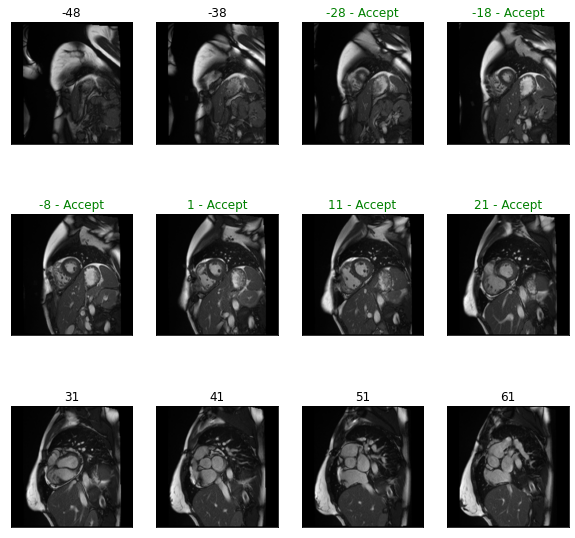

In [99]:
# Display each slice location, with associated label. 
# If manually selected cases are available, these labels are automatically used
fig, ax = plt.subplots(int(np.ceil(len(slice_locations)/4)), 4, figsize=(10,10))

for i in range(4):
    for j in range(4):
        
        idx = i*4 + j
        if idx > len(slice_locations)-1:
            break
            
        # select row and slice id
        row_df = sa_final_df.iloc[idx] 
        slice_id = row_df['Slice ID']

        # the image from the ES phase is automatically selected
        ax[i,j].imshow(phaseSelector.volume[slice_id, es_phase, :, :, 0], cmap='gray')
        
        if "manual_selected_ids" in locals():
            if slice_id in manual_selected_ids:
                ax[i,j].set_title('{} - Accept'.format(int(row_df['Slice Location'])))
                ax[i,j].title.set_color('green')
            else:
                ax[i,j].set_title('{}'.format(int(row_df['Slice Location'])))
        else:
            if row_df['Pred Label'] == 'Good':
                ax[i,j].set_title('{} - Accept'.format(int(row_df['Slice Location'])))
                ax[i,j].title.set_color('green')
            else:
                ax[i,j].set_title('{}'.format(int(row_df['Slice Location'])))
        
        # format plot
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

plt.show()

#### Useability Note

Manually selected SAX slices typically range from base to apex, with every other slice selected. However, both the segmentation and landmark localization models struggle on the most apical and basal slices. Consequently, these slices are optimally excluded from the automated pipeline. In almost all cases I processed, the most basal manual SAX slice was too far basal for use in the automated pipeline. Basal slices that transect the valve planes and/or right ventricular outflow tract should be excluded. 

I typically select 3 to 4 SAX slices, ranging from just below the valve planes to the apex. I select every other slice, similar to the manual cases. 

In [103]:
# make widget with sa slice options
items = []
for i, row in sa_final_df.iterrows():
        if row['Pred Label'] == 'Good':
            items.append(widgets.Checkbox(
                value=True,
                description='Slice {} - {}'.format(i, float(row['Slice Location'])),
                disabled=False,
                indent=False))
        else:
            items.append(widgets.Checkbox(
                value=False,
                description='Slice {} - {}'.format(i, float(row['Slice Location'])),
                disabled=False,
                indent=False))

grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=False, description='Slice 0 - -48.9', indent=False), Checkbox(value=False, de…

In [104]:
# remove undesired SA series
good_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        good_locations.append(float(items[i].description.split(' ')[-1]))
        
good_locations

[-28.9, -8.9, 11.1, 21.1]

### Step 4: Landmark Localization

The following code can be used to perform landmark localization. The points that are predicted are the following:

* SA View: right ventricular insertion points
* 4CH View: mitral valve insertions, tricuspid valve inserts, left ventricular apex
* 3CH View: mitral valve insertions, aortic valve insertions
* RVOT View: pulmonary valve insertions

#### Useability Note

The RV insertion points from the SAX stack are typically fairly accurate; consequently, normalization and test time augmentations (both of which significantly increase required processing time) may not be necessary. For the 4CH, 3CH, and RVOT views, I recommend including both normalization and at least 5 test time augmentations. 

### 4.1 Short-Axis RV Inserts

Predict the RV insertion points from the SAX stack.

In [105]:
# convert selected slice locations into slice IDs
selected_sa_ids = list(sa_final_df[sa_final_df['Slice Location'].isin(good_locations)]['Slice ID'])

sa_final_df[sa_final_df['Slice Location'].isin(good_locations)]

,Slice ID,Slice Location,Pred Value,Pred Label,Manual Label
2,22,-28.9,1.0,Good,Not available
4,20,-8.9,1.0,Good,Not available
6,18,11.1,1.0,Good,Not available
7,17,21.1,0.9,Good,Not available


In [106]:
from landmarklocalization import LandmarkLocalization

# Initiate a landmark localization module in the short-axis view
ShortAxisLoc = LandmarkLocalization( os.path.join(dst, patient), slice_info_df, 'SA' )

# load model
ShortAxisLoc.load_tensorflow_model()

# Settings
ShortAxisLoc.num_phases = num_phases                             # calculated from view selections
ShortAxisLoc.test_time_augmentations = False                     # Use test time augmentations to improve predictions (often not necessary)
ShortAxisLoc.normalize_predictions = True                        # Smooth predictions throughout cardiac cycle
ShortAxisLoc.number_of_test_augmentations = 5                    # Number of test-time predictions

# Generate Input
ShortAxisLoc.generate_mapping_dictionary()
ShortAxisLoc.generate_complete_volume()

# Make landmark predictions for ED phase
ShortAxisLoc.predict_landmarks(prediction_phase=0)
ed_output = ShortAxisLoc.output

# Make landmark predictions for ES phase
ShortAxisLoc.predict_landmarks(prediction_phase=int(es_phase_float * ShortAxisLoc.num_phases) )
es_output = ShortAxisLoc.output

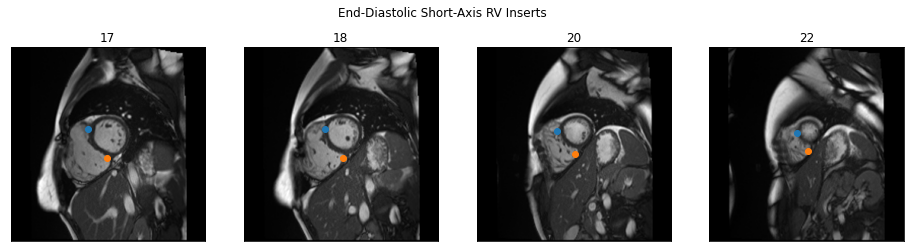

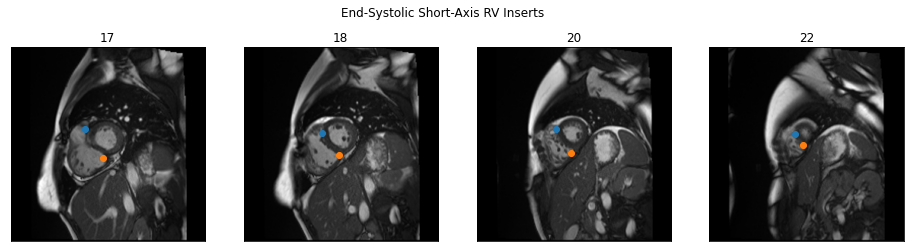

In [107]:
# Store outputs and display inputs/predictions for review
volume = ShortAxisLoc.volume

cols = 4
rows = int(np.ceil(len(selected_sa_ids)/cols))

plt.figure(figsize = (16,4*rows))
count = 1
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    if slice_id in selected_sa_ids:
        p1 = slice[3]
        p2 = slice[4]
        image = volume[slice_id, 0, :, :, 0]

        ax = plt.subplot(rows, cols, count)
        ax.imshow(image, cmap='gray')
        if p1 != None:
            ax.scatter(x=p1[1], y=p1[0])
        if p2 != None:
            ax.scatter(x=p2[1], y=p2[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(slice_id)
        count += 1
plt.suptitle('End-Diastolic Short-Axis RV Inserts')   
plt.show()

plt.figure(figsize = (16,4*rows))
count = 1
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    if slice_id in selected_sa_ids:
        p1 = slice[3]
        p2 = slice[4]
        image = volume[slice_id, int(es_phase_float * ShortAxisLoc.num_phases), :, :, 0]

        ax = plt.subplot(rows, cols, count)
        ax.imshow(image, cmap='gray')
        if p1 != None:
            ax.scatter(x=p1[1], y=p1[0])
        if p2 != None:
            ax.scatter(x=p2[1], y=p2[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(slice_id)
        count += 1
plt.suptitle('End-Systolic Short-Axis RV Inserts')   
plt.show()

In [108]:
# store the RV insert predictions for both the ED and ES phases
sa_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'RV1', 'RV2'])
sa_df = sa_df.append(pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'RV1', 'RV2']))
sa_df = sa_df[sa_df['Slice ID'].isin(selected_sa_ids)]
sa_df.reset_index(inplace=True, drop=True)

sa_df

,Slice ID,View,Time Frame,RV1,RV2
0,17,SA,0,"[107, 101]","[145, 127]"
1,18,SA,0,"[107, 107]","[145, 130]"
2,20,SA,0,"[110, 106]","[141, 130]"
3,22,SA,0,"[113, 115]","[136, 129]"
4,17,SA,11,"[108, 98]","[146, 121]"
5,18,SA,11,"[112, 103]","[142, 125]"
6,20,SA,11,"[108, 104]","[139, 124]"
7,22,SA,11,"[114, 113]","[128, 123]"


### 4.2 Four Chamber Landmark Localization

Predict the MV inserts, TV inserts, and LV apex from the 4CH view. Select only one 4CH slice for inclusion in the final model. 


#### Useability Note

For the landmark localization models, cardiac orientation matters. These models were trained on images with the LV apex pointed towards the top right corner of the image, with the RV (and tricuspid valve) located above the LV (the standard orientation). If this is not the case for your images, utilizing the provided settings "flip_ud" (flip image up/down) and "flip_lr" (flip image left/right) can be used to achieve the correct orientation. This is necessary to achieve useable predictions if your orientation is incorrect. 

In [182]:
# Initiate a landmark localization module in the four chamber view
FourChamberLoc = LandmarkLocalization( os.path.join(dst, patient), slice_info_df, '4CH' )

# Load tensorflow model and inputs
FourChamberLoc.load_tensorflow_model()

# Settings
FourChamberLoc.num_phases = num_phases                              # Change number of phases if necessary
flip_ud = True
flip_lr = False
FourChamberLoc.test_time_augmentations = True                       # Use test time augmentations to improve predictions (often not necessary)
FourChamberLoc.normalize_predictions = True                         # Smooth predictions throughout cardiac cycle
FourChamberLoc.number_of_test_augmentations = 5                     # Number of test-time predictions
FourChamberLoc.flip_ud = flip_ud
FourChamberLoc.flip_lr = flip_lr

# Generate Inputs
FourChamberLoc.generate_mapping_dictionary()
FourChamberLoc.generate_complete_volume()

# Make predictions for ED phase
FourChamberLoc.predict_landmarks(prediction_phase=0)
ed_output = FourChamberLoc.output

# Make predictions for ES phase
FourChamberLoc.predict_landmarks(prediction_phase=int(es_phase_float * FourChamberLoc.num_phases) )
es_output = FourChamberLoc.output

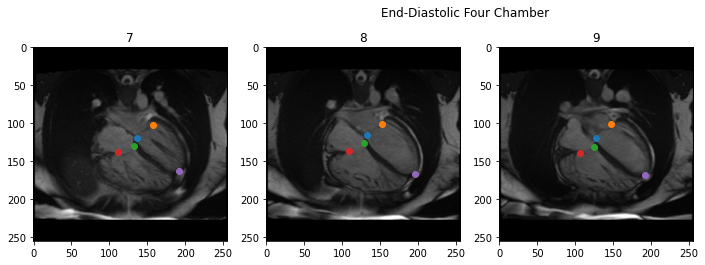

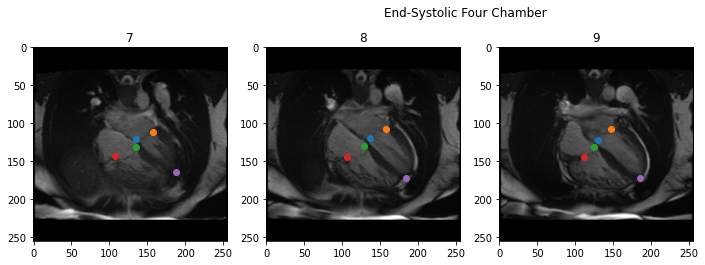

In [183]:
# display predictions
volume = FourChamberLoc.volume

cols = 4
rows = int(np.ceil(len(ed_output)/cols))

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]
    p5 = slice[7]

    image = volume[slice_id, 0, :, :, 0]
    if flip_ud == True:
        image = np.flipud(image)
    elif flip_lr == True:
        image = np.fliplr(image)

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1,p2,p3,p4,p5]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.suptitle('End-Diastolic Four Chamber')  
plt.show()

cols = 4
rows = int(np.ceil(len(es_output)/cols))

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]
    p5 = slice[7]

    image = volume[slice_id, int(es_phase_float * FourChamberLoc.num_phases), :, :, 0]    
    
    if flip_ud == True:
        image = np.flipud(image)
    elif flip_lr == True:
        image = np.fliplr(image)

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1,p2,p3,p4,p5]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.suptitle('End-Systolic Four Chamber')  
plt.show()

In [184]:
# SELECT ONE 4CH SLICE FOR USE IN THE MODEL
options = list(slice_info_df[slice_info_df['View'] == '4CH']['Slice ID'])
items = [widgets.Checkbox(
    value=False,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=False, description='Slice ID 7', indent=False), Checkbox(value=False, descrip…

In [185]:
# record selected slice and landmarks
selected_4ch_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_4ch_locations.append(int(items[i].description.split(' ')[-1]))
        
four_chamber_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'TV1', 'TV2', 'LVA'])
four_chamber_df = four_chamber_df.append(
    pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'TV1', 'TV2', 'LVA'])
)
four_chamber_df = four_chamber_df[four_chamber_df['Slice ID'].isin(selected_4ch_locations)]
four_chamber_df.reset_index(inplace=True, drop=True)
four_chamber_df

,Slice ID,View,Time Frame,MV1,MV2,TV1,TV2,LVA
0,8,4CH,0,"[116, 132]","[102, 153]","[126, 128]","[137, 109]","[168, 196]"
1,8,4CH,11,"[120, 136]","[108, 157]","[130, 129]","[145, 106]","[173, 184]"


#### Useability Note

If the landmark localization predictions are incorrect, they can be manually corrected using the Annotate module. Ideally, this tool will be improved in future versions of this notebook. 

Referencing the landmark dataframe above, enter the index number (0 or 1), slice ID, and landmarks to correct. The Annotate class will open a matplotlib figure of the view / slice ID selected. Draw a line on the image across the valve plane by clicking twice, once at each valve insertion point. Once the line has been drawn, save the correct valve insertion points by running annotator.update() in the cell block below. The 4CH views are typically accurate; however, the AV and PV insertion points below may need to be corrected. 

### 4.3 Three Chamber Landmark Localization

Predict MV insertions and AV insertions from the 3CH view. 

In [188]:
# Initiate a landmark localization module in the three chamber view
ThreeChamberLoc = LandmarkLocalization( os.path.join(dst, patient) , slice_info_df, '3CH' )

# Load tensorflow model and inputs
ThreeChamberLoc.load_tensorflow_model()

# Settings
ThreeChamberLoc.num_phases = num_phases                # Change number of phases if necessary
flip_ud = False
flip_lr = False
ThreeChamberLoc.normalize_predictions = True
ThreeChamberLoc.test_time_augmentations = True
ThreeChamberLoc.number_of_test_augmentations = 5
ThreeChamberLoc.flip_ud = flip_ud
ThreeChamberLoc.flip_lr = flip_lr

# Generate Input
ThreeChamberLoc.generate_mapping_dictionary()
ThreeChamberLoc.generate_complete_volume()

# Make predictions for ED phase
ThreeChamberLoc.predict_landmarks(prediction_phase=0)
ed_output = ThreeChamberLoc.output

# Make predictions for ES phase
ThreeChamberLoc.predict_landmarks(prediction_phase = int(es_phase_float * ThreeChamberLoc.num_phases))
es_output = ThreeChamberLoc.output

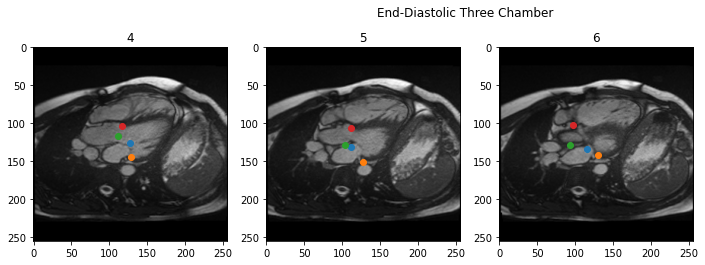

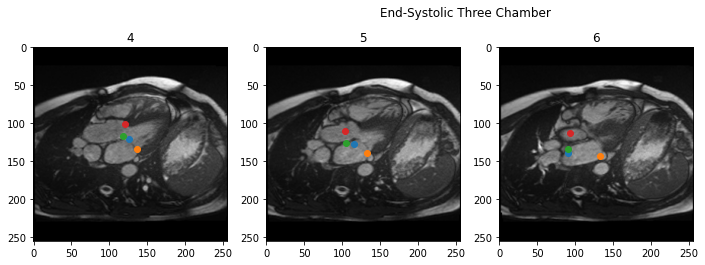

In [189]:
%matplotlib inline
# plot 3CH predictions
volume = ThreeChamberLoc.volume

cols = 4
rows = int(np.ceil(len(ed_output)/cols))

plt.figure(figsize = (16,4*rows))
    
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]

    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    
    if flip_ud:
        image = np.flipud(image)
    elif flip_lr:
        image = np.fliplr(image)
        
    ax.imshow(image, cmap='gray')
    for p in [p1, p2, p3, p4]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass

plt.suptitle('End-Diastolic Three Chamber')      
plt.show()

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]
    p3 = slice[5]
    p4 = slice[6]

    image = volume[slice_id, int(es_phase_float * ThreeChamberLoc.num_phases), :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    
    if flip_ud:
        image = np.flipud(image)
    elif flip_lr:
        image = np.fliplr(image)
        
    ax.imshow(image, cmap='gray')
    for p in [p1, p2, p3, p4]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass

plt.suptitle('End-Systolic Three Chamber')    
plt.show()

In [190]:
# SELECT ONE 3CH SLICE TO INCLUDE IN THE MODEL
options = list(slice_info_df[slice_info_df['View'] == '3CH']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))
grid

GridBox(children=(Checkbox(value=True, description='Slice ID 4', indent=False), Checkbox(value=True, descripti…

In [191]:
selected_3ch_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_3ch_locations.append(int(items[i].description.split(' ')[-1]))
        
three_chamber_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'AV1', 'AV2'])
three_chamber_df = three_chamber_df.append(
    pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'MV1', 'MV2', 'AV1', 'AV2'])
)

three_chamber_df = three_chamber_df[three_chamber_df['Slice ID'].isin(selected_3ch_locations)]
three_chamber_df.reset_index(inplace=True, drop=True)
three_chamber_df

,Slice ID,View,Time Frame,MV1,MV2,AV1,AV2
0,4,3CH,0,"[127, 127]","[145, 128]","[117, 112]","[104, 116]"
1,4,3CH,11,"[121, 126]","[134, 136]","[117, 118]","[101, 120]"


<IPython.core.display.Javascript object>


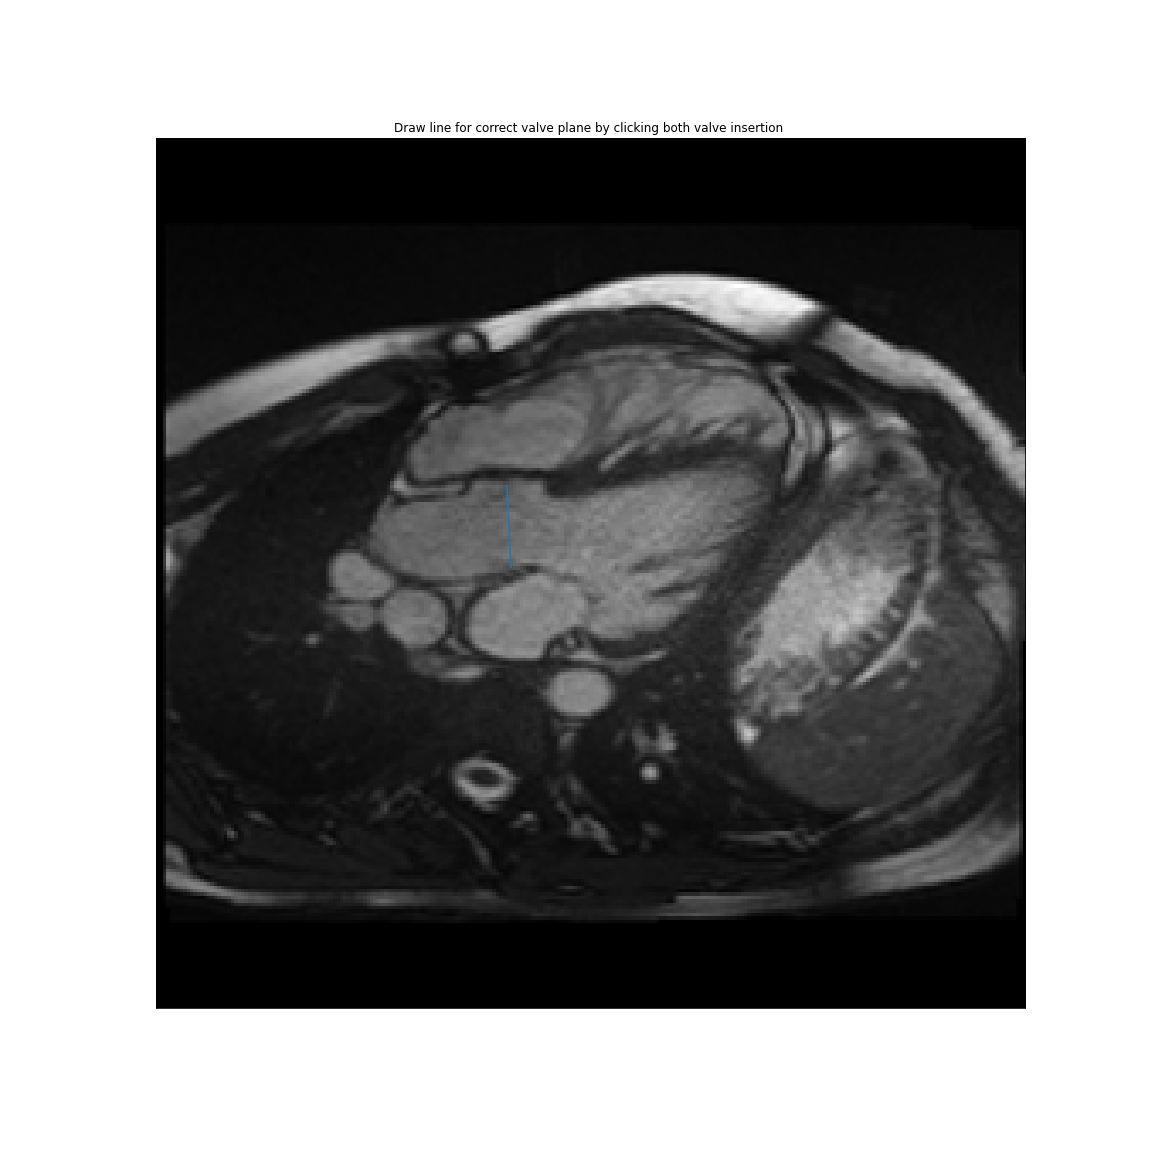

In [202]:
# if necessary, update landmark predictions
from annotations import Annotate

# Settings
index = 0
slice_id = 4
labels = ['AV1', 'AV2'] # should be list of labels (e.g., ['AV1', 'AV2'])

annotator = Annotate(three_chamber_df, volume, index, slice_id, labels)

%matplotlib notebook
annotator.plot()

<IPython.core.display.Javascript object>


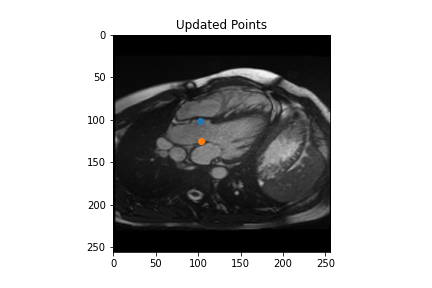

,Slice ID,View,Time Frame,MV1,MV2,AV1,AV2
0,4,3CH,0,"[126, 111]","[144, 125]","[101, 102]","[125, 104]"
1,4,3CH,11,"[122, 116]","[141, 136]","[97, 108]","[121, 109]"


In [203]:
# update dataframe and display
three_chamber_df = annotator.update()
three_chamber_df

### 4.4 RVOT Landmark Localization

Predicte PV insertion points from the RVOT view

In [204]:
# Initiate a landmark localization module in the RVOT view
RVOTLoc = LandmarkLocalization( os.path.join(dst, patient) , slice_info_df, 'RVOT' )

# Load tensorflow model
RVOTLoc.load_tensorflow_model()

# Settings
RVOTLoc.num_phases = num_phases                # Change number of phases if necessary
RVOTLoc.normalize_predictions = False
RVOTLoc.test_time_augmentations = False
RVOTLoc.number_of_test_augmentations = 5

# Generate input
RVOTLoc.generate_mapping_dictionary()
RVOTLoc.generate_complete_volume()

# Make predictions for ED phase
RVOTLoc.predict_landmarks(prediction_phase=0)
ed_output = RVOTLoc.output

# Make predictions for ES phase
RVOTLoc.predict_landmarks(prediction_phase= int(es_phase_float * RVOTLoc.num_phases))
es_output = RVOTLoc.output

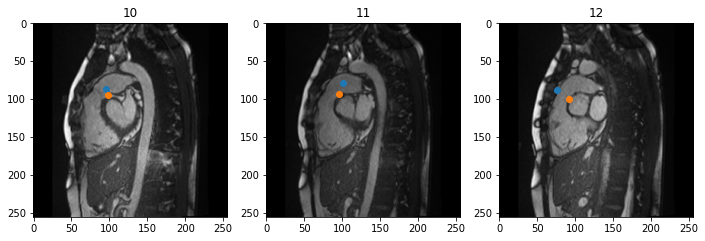

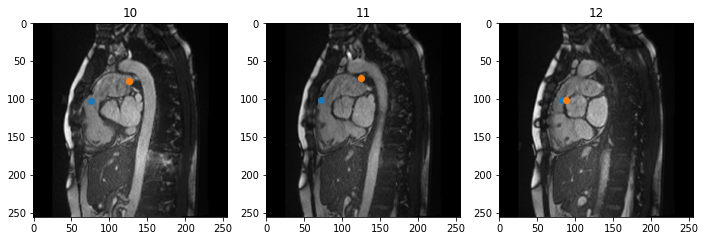

In [205]:
# display landmark predictions
%matplotlib inline
volume = RVOTLoc.volume

cols = 4
rows = int(np.ceil(len(ed_output)/cols))

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(ed_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]

    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1, p2]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.show()

plt.figure(figsize = (16,4*rows))
for i, slice in enumerate(es_output):
    slice_id = slice[0]
    p1 = slice[3]
    p2 = slice[4]

    image = volume[slice_id, int(es_phase_float * RVOTLoc.num_phases), :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    for p in [p1, p2]:
        try:
            ax.scatter(x=p[1], y=p[0])
        except:
            pass
    
plt.show()

In [206]:
# SELECT ONE RVOT VIEW TO INCLUDE IN THE MODEL
options = list(slice_info_df[slice_info_df['View'] == 'RVOT']['Slice ID'])
items = [widgets.Checkbox(
    value=False,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=False, description='Slice ID 10', indent=False), Checkbox(value=False, descri…

In [207]:
selected_rvot_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_rvot_locations.append(int(items[i].description.split(' ')[-1]))
        
rvot_df = pd.DataFrame(ed_output, columns=['Slice ID', 'View', 'Time Frame', 'PV1', 'PV2'])
rvot_df = rvot_df.append(pd.DataFrame(es_output, columns=['Slice ID', 'View', 'Time Frame', 'PV1', 'PV2']))
rvot_df = rvot_df[rvot_df['Slice ID'].isin(selected_rvot_locations)]
rvot_df.reset_index(inplace=True, drop=True)
rvot_df

,Slice ID,View,Time Frame,PV1,PV2
0,12,RVOT,0,"([88], [76])","([100], [92])"
1,12,RVOT,11,"([101], [83])","([102], [88])"


If necessary, update the PV insertion point predictions. 

<IPython.core.display.Javascript object>


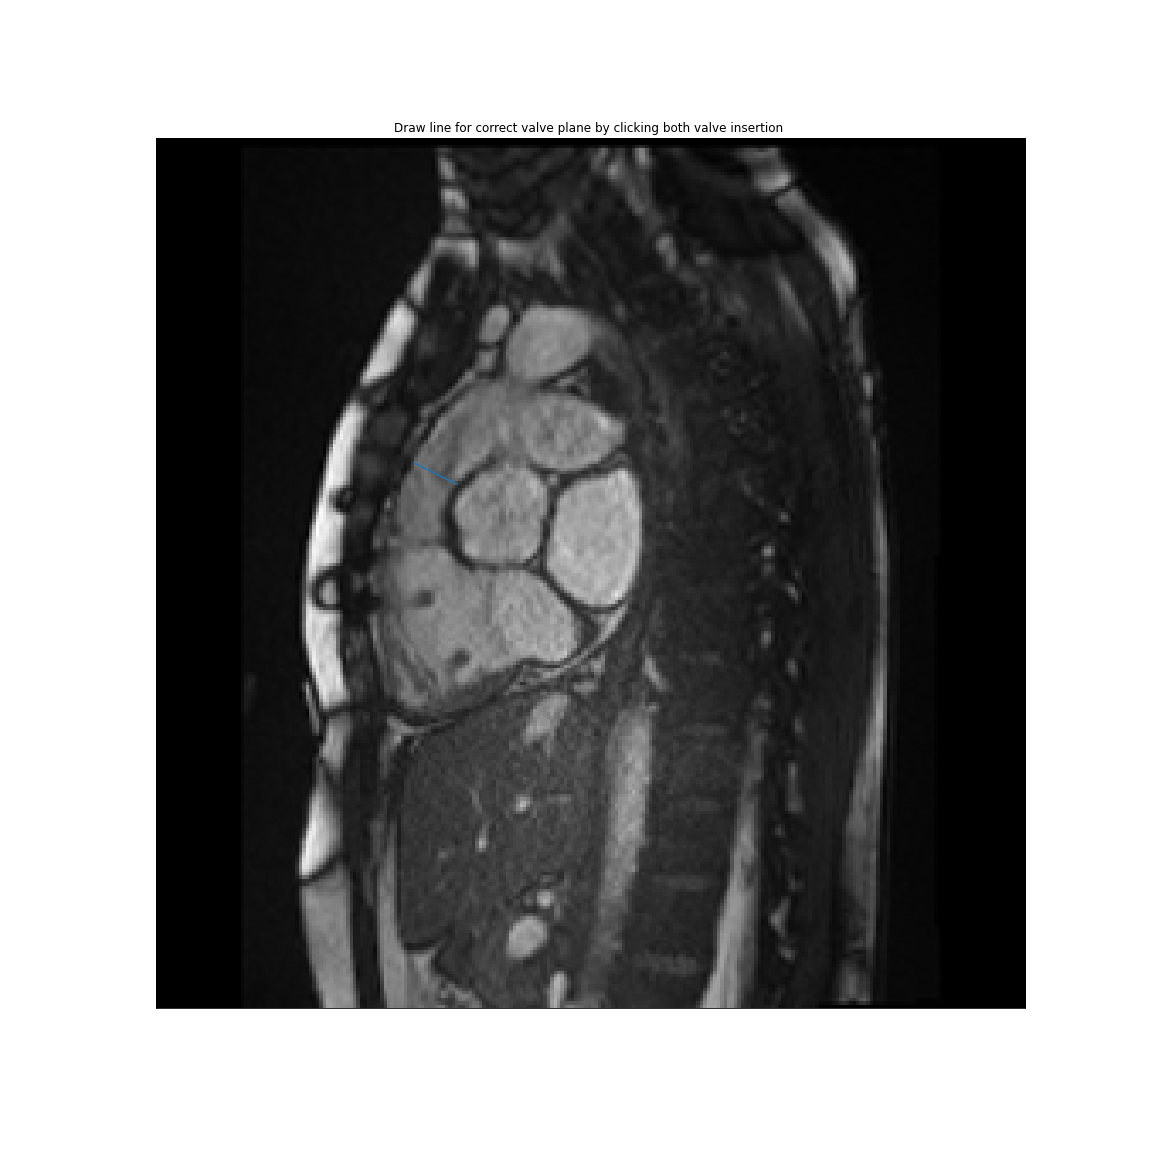

In [208]:
from annotations import Annotate

# if necessary, update landmark predictions
# Settings
index = 1
slice_id = 12
labels = ['PV1', 'PV2'] # should be list of labels (e.g., ['AV1', 'AV2'])

annotator = Annotate(rvot_df, volume, index, slice_id, labels)

%matplotlib notebook
annotator.plot()

<IPython.core.display.Javascript object>


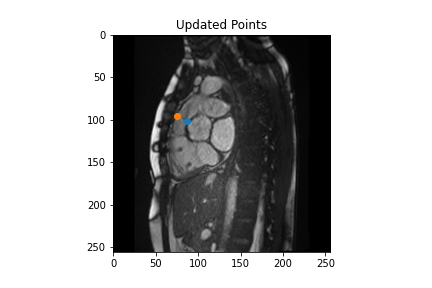

,Slice ID,View,Time Frame,PV1,PV2
0,12,RVOT,0,"([88], [76])","([100], [92])"
1,12,RVOT,11,"[101, 87]","[95, 75]"


In [209]:
# update dataframe and display
rvot_df = annotator.update()
rvot_df

In [210]:
# save all dataframes to csv
landmarks_df = pd.concat([sa_df, four_chamber_df, three_chamber_df, rvot_df])
landmarks_df.to_csv(os.path.join( os.path.join(dst, patient), 'landmark_points.csv'))
landmarks_df

,Slice ID,View,Time Frame,RV1,RV2,MV1,MV2,TV1,TV2,LVA,AV1,AV2,PV1,PV2
0,17,SA,0,"[107, 101]","[145, 127]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18,SA,0,"[107, 107]","[145, 130]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,SA,0,"[110, 106]","[141, 130]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,SA,0,"[113, 115]","[136, 129]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,SA,11,"[108, 98]","[146, 121]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,18,SA,11,"[112, 103]","[142, 125]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20,SA,11,"[108, 104]","[139, 124]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,22,SA,11,"[114, 113]","[128, 123]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,8,4CH,0,NaN,NaN,"[116, 132]","[102, 153]","[126, 128]","[137, 109]","[168, 196]",NaN,NaN,NaN,NaN
1,8,4CH,11,NaN,NaN,"[120, 136]","[108, 157]","[130, 129]","[145, 106]","[173, 184]",NaN,NaN,NaN,NaN


#### 4.5 Select 2CH Views

We do not include landmark points from the two-chamber views; however, it is still optimal to include the segmentations from these views in the final model. If available, select one two-chamber left and one two-chamber right view for inclusion in the model.

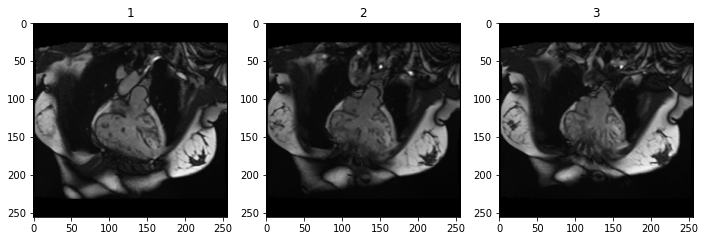

In [211]:
%matplotlib inline
# select two-chamber right view, if available
two_chamber_df = slice_info_df[slice_info_df['View'] == '2CH RT']

cols = 4
rows = 1

plt.figure(figsize = (16,4*rows))
two_chamber_df = two_chamber_df.reset_index()
for i, row in two_chamber_df.iterrows():
    
    slice_id = row['Slice ID']
    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    
plt.show()

In [212]:
options = list(slice_info_df[slice_info_df['View'] == '2CH RT']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=True, description='Slice ID 1', indent=False), Checkbox(value=True, descripti…

In [213]:
# save selected 2CH RT locations
selected_2ch_rt_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_2ch_rt_locations.append(int(items[i].description.split(' ')[-1]))

out = []
for loc in selected_2ch_rt_locations:
    out.append([loc, '2CH RT', 0])  
    out.append([loc, '2CH RT', es_phase])
    
two_chamber_rt_df = pd.DataFrame(out, columns=['Slice ID', 'View', 'Time Frame'])
two_chamber_rt_df

,Slice ID,View,Time Frame
0,1,2CH RT,0
1,1,2CH RT,11


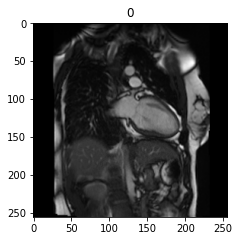

In [214]:
# selecte two-chamber left views, if available
two_chamber_lt_df = slice_info_df[slice_info_df['View'] == '2CH LT']

cols = 4
rows = 1

plt.figure(figsize = (16,4*rows))
two_chamber_lt_df = two_chamber_lt_df.reset_index()
for i, row in two_chamber_lt_df.iterrows():
    
    slice_id = row['Slice ID']
    image = volume[slice_id, 0, :, :, 0]

    ax = plt.subplot(rows,cols,i+1)
    ax.set_title(slice_id)
    ax.imshow(image, cmap='gray')
    
plt.show()

In [215]:
options = list(slice_info_df[slice_info_df['View'] == '2CH LT']['Slice ID'])
items = [widgets.Checkbox(
    value=True,
    description='Slice ID {}'.format(i),
    disabled=False,
    indent=False
) for i in options]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))

grid

GridBox(children=(Checkbox(value=True, description='Slice ID 0', indent=False),), layout=Layout(grid_template_…

In [216]:
# save selected 2CH LT locations
selected_2ch_lt_locations = []
for i in range(len(items)):
    value = items[i].value
    if value == True:
        selected_2ch_lt_locations.append(int(items[i].description.split(' ')[-1]))

out = []
for loc in selected_2ch_lt_locations:
    out.append([loc, '2CHLT', 0])  
    out.append([loc, '2CHLT', es_phase])
    
two_chamber_lt_df = pd.DataFrame(out, columns=['Slice ID', 'View', 'Time Frame'])
two_chamber_lt_df

,Slice ID,View,Time Frame
0,0,2CHLT,0
1,0,2CHLT,11


### 5. Segmentation

Myocardial segmentation is performed using nnUnet. Double check that the input and output folders are correct below. 

In [222]:
# define I/O parameters for nnUnet segmentation
input_folder = "../data/final/" + patient
output_folder = "../data/segmentations/" + patient

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

# default nnUnet parameters
folds = 0
save_npz = False
num_threads_preprocessing = 1
num_threads_nifti_save = 1
lowres_segmentations = None
part_id = False
num_parts = 1
mode = "normal"

# nnunet models / tasks
model_folder = "/home/ubuntu/CAP/CAP-FullAutomation/models/Segmentation"
tasks = ['Task101_SAX', 'Task108_4CH', 'Task107_3CH', 'Task109_RVOT', 'Task110_RVT', 'Task106_2CH']
views = ['SA', '4CH', '3CH', 'RVOT', 'RVT', '2CHLT']

For use with the nnUnet pipeline (the model used for segmentation), we need to convert each of the relevant image files to a NIFTI file. The below code used Simple ITK to accomplish this task.

In [223]:
import SimpleITK as sitk

# ensure directory for nii files exists
if not os.path.isdir(os.path.join(input_folder)):
    os.mkdir(os.path.join(input_folder))
    
# generate input volume
ShortAxisLoc = LandmarkLocalization( os.path.join(dst, patient), slice_info_df, 'SA' )
ShortAxisLoc.num_phases = num_phases # Change number of phases if necessary
ShortAxisLoc.generate_mapping_dictionary()
ShortAxisLoc.generate_complete_volume()
volume = ShortAxisLoc.volume

# select ED and ES images for each cardiac view, and convert to nifti
view_dataframes = [sa_df, four_chamber_df, three_chamber_df, rvot_df, two_chamber_rt_df, two_chamber_lt_df]
views = ['SA', '4CH', '3CH', 'RVOT', 'RVT', '2CHLT']

for view, df in enumerate(view_dataframes):
    
    # ensure view folder exists
    if not os.path.isdir(os.path.join(input_folder, views[view])):
        os.mkdir(os.path.join(input_folder, views[view]))
        
    for i, row in df.iterrows():
        slice_id = row['Slice ID']
        phase = row['Time Frame']
        
        # extract image array from volume of all slices
        image_array = volume[slice_id, phase, :, :, 0]
        
        # expand dimensions
        image_array = image_array[None, None]
        
        # spacing defined here - could set to pixel spacing instead of 1,1. First value is simply a dummy value since we only
        # have 2D, just needs to be larger than the x and y spacing. 
        spacing = (999,1,1)
        for j, k in enumerate(image_array): # keep for loop here in case additional slices/modalities are needed later
            itk_image = sitk.GetImageFromArray(k)
            itk_image.SetSpacing(list(spacing)[::-1])

            # write nii files to folder for use with nnUnet - only need to save images that need predictions (i.e., ED and ES
            # for selected views/slices. 
            sitk.WriteImage(itk_image, os.path.join(input_folder, views[view],
                                                    '{}_{}_{}'.format(views[view], 
                                                                   slice_id, phase) + "_%04.0d.nii.gz" % j))

In [220]:
# reset gpu memory (necessary if tensorflow/landmark models were loaded previously)
# ONLY RUN THIS ONCE OR THE KERNEL MAY CRASH
tf.keras.backend.clear_session()
torch.cuda.empty_cache()

from numba import cuda
cuda.select_device(0)
cuda.close()

ModuleNotFoundError: No module named 'numba'

In the below code, we will iterate through each of the cardiac views and use the appropriate nnUnet model to make predictions. Models are saved under models/Segmentation/ and are organized by task (i.e., view). 

In [224]:
# loop through each view
for i, view in enumerate(views):
    
    print('*** Making predictions for {} images ***'.format(view))

    # Define the trained model to use (Specified by the Task)
    model_folder_name = "../models/Segmentation/{}/nnUNetTrainerV2__nnUNetPlansv2.1/".format(tasks[i])

    view_input_folder = os.path.join(input_folder, view)
    view_output_folder = os.path.join(output_folder, view)

    # ensure output folder exists
    if not os.path.isdir(view_output_folder):
        os.mkdir(view_output_folder)
        
    if len(os.listdir(view_input_folder)) > 0:

        # run nnUnet inference directly from folder of 2D nii files
        predict_from_folder(model_folder_name, view_input_folder, view_output_folder, folds, save_npz, num_threads_preprocessing,
                                num_threads_nifti_save, lowres_segmentations, part_id, num_parts, not False, mode=mode)

        print('Done with {}\n'.format(view))

*** Making predictions for SA images ***
This model expects 1 input modalities for each image
Found 8 unique case ids, here are some examples: ['SA_20_11' 'SA_20_0' 'SA_17_0' 'SA_18_0' 'SA_17_11' 'SA_18_0' 'SA_17_11'
 'SA_18_0']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
emptying cuda cache
loading parameters for folds, 0
using the following model files:  ['../models/Segmentation/Task101_SAX/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0\\model_final_checkpoint.model']
starting preprocessing generator
starting prediction...
preprocessing ../data/segmentations/venus1\SA\SA_17_0.nii.gz
using preprocessor PreprocessorFor2D
before crop: (1, 1, 256, 256) after crop: (1, 1, 255, 207) spacing: [999.   1.   1.] 

separate z, order in z is 0 order inplane is 3
separate z, order in z is 0 order inplane is 1
before: {'spacing': array([999.,   1.,   1.]), 'spacing_transposed': array([999.,   1.,   1.]), 'data.shape (data is transposed)': (1, 1,

predicting ../data/segmentations/venus1\4CH\4CH_8_11.nii.gz
debug: mirroring True mirror_axes (0, 1)
inference done. Now waiting for the segmentation export to finish...
WARNING! Cannot run postprocessing because the postprocessing file is missing. Make sure to run consolidate_folds in the output folder of the model first!
The folder you need to run this in is ../models/Segmentation/Task108_4CH/nnUNetTrainerV2__nnUNetPlansv2.1/
Done with 4CH

*** Making predictions for 3CH images ***
This model expects 1 input modalities for each image
Found 2 unique case ids, here are some examples: ['3CH_4_11' '3CH_4_0']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
emptying cuda cache
loading parameters for folds, 0
using the following model files:  ['../models/Segmentation/Task107_3CH/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0\\model_final_checkpoint.model']
starting preprocessing generator
starting prediction...
preprocessing ../data/segmentat

before crop: (1, 1, 256, 256) after crop: (1, 1, 254, 206) spacing: [999.   1.   1.] 

separate z, order in z is 0 order inplane is 3
separate z, order in z is 0 order inplane is 1
before: {'spacing': array([999.,   1.,   1.]), 'spacing_transposed': array([999.,   1.,   1.]), 'data.shape (data is transposed)': (1, 1, 254, 206)} 
after:  {'spacing': array([999.        ,   1.34765625,   1.34765625]), 'data.shape (data is resampled)': (1, 1, 188, 153)} 

normalization...
normalization done
(1, 1, 188, 153)
This worker has ended successfully, no errors to report
predicting ../data/segmentations/venus1\2CHLT\2CHLT_0_0.nii.gz
debug: mirroring True mirror_axes (0, 1)
predicting ../data/segmentations/venus1\2CHLT\2CHLT_0_11.nii.gz
debug: mirroring True mirror_axes (0, 1)
inference done. Now waiting for the segmentation export to finish...
WARNING! Cannot run postprocessing because the postprocessing file is missing. Make sure to run consolidate_folds in the output folder of the model first!
Th

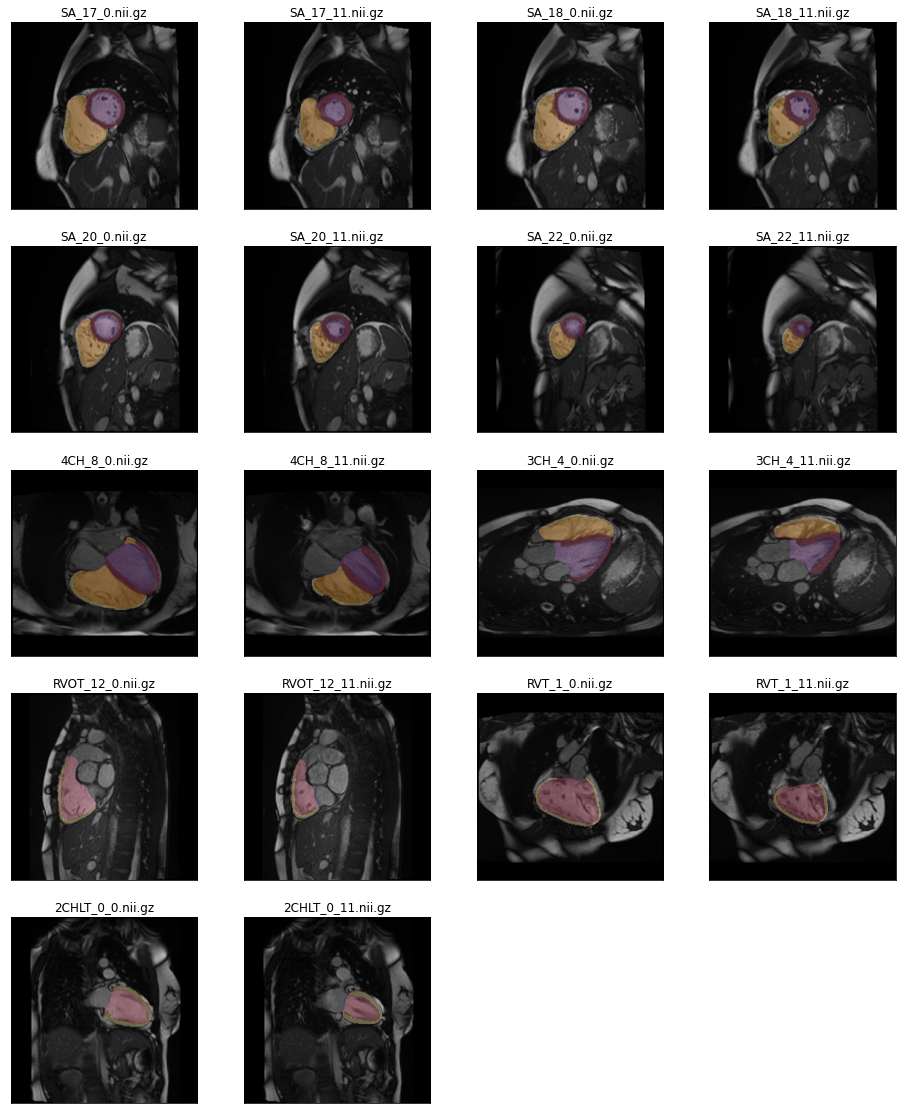

In [225]:
# display generated segmentations
import nibabel as nib
%matplotlib inline

# view some of the segmentations
plt.figure(figsize=(16,24))
count = 1
for i, view in enumerate(views):
    
    view_output_folder = os.path.join(output_folder, view)
    view_input_folder = os.path.join(input_folder, view)
    segs = os.listdir(view_output_folder)
    segs = [x for x in segs if '.nii.gz' in x]
    
    if len(segs) > 0:
    
        # load first image
        for idx in range(len(segs)):
            subplot = count

            # change input name to include modality info (nnUnet formatting)
            prefix = segs[idx].split('.')
            input_name = prefix[0] + '_0000.' + prefix[1] + '.' + prefix[2]

            seg = nib.load(os.path.join(view_output_folder, segs[idx]))
            img = nib.load(os.path.join(view_input_folder, input_name))

            ax = plt.subplot(6,4,subplot)
            ax.imshow(np.array(img.dataobj).T[0,:,:], cmap='gray')
            ax.imshow(np.array(seg.dataobj).T[0,:,:], alpha=0.3, cmap='inferno')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(segs[idx]) 
            count += 1
    
plt.show()   

### 6. Extract Guide Points from Segmentations and Landmarks

Processes the segmentations and landmarks by extracting contours for inclusion in the guide point file. As a part of this process, we perform an inverse transform from image to model coordinates using the affine matrix provided in the DICOM header. Landmark points are loaded from the csv file that was saved previously. To display guide points as they are generated, set display = True in the .extract_guidepoints() function. 

In [243]:
def parse_string(s):
    try:
        if ',' in s and 'array' not in s:
            p1 = int(s.split('[')[1].split(',')[0])
            p2 = int(s.split('[')[1].split(',')[1].rstrip(']'))
            return np.array(p1, dtype=np.int64), np.array(p2, dtype=np.int64)
        elif 'array' in s:
            p1 = int(s.split('array([')[1].split(']')[0])
            p2 = int(s.split('array([')[2].split('])')[0])
            return np.array(p1, dtype=np.int64), np.array(p2, dtype=np.int64)
        else:
            return s
    except:
        return s
    
# reload landmarks dataframe if necessary
landmarks_df = pd.read_csv(os.path.join('../data/processed', patient, 'landmark_points.csv'),converters={'object':parse_string})
landmarks_df = landmarks_df.drop(columns=['Unnamed: 0']).applymap(parse_string)
landmarks_df 

,Slice ID,View,Time Frame,RV1,RV2,MV1,MV2,TV1,TV2,LVA,AV1,AV2,PV1,PV2
0,17,SA,0,"(107, 101)","(145, 127)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18,SA,0,"(107, 107)","(145, 130)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,SA,0,"(110, 106)","(141, 130)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,SA,0,"(113, 115)","(136, 129)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,SA,11,"(108, 98)","(146, 121)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,18,SA,11,"(112, 103)","(142, 125)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20,SA,11,"(108, 104)","(139, 124)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,22,SA,11,"(114, 113)","(128, 123)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,4CH,0,NaN,NaN,"(116, 132)","(102, 153)","(126, 128)","(137, 109)","(168, 196)",NaN,NaN,NaN,NaN
9,8,4CH,11,NaN,NaN,"(120, 136)","(108, 157)","(130, 129)","(145, 106)","(173, 184)",NaN,NaN,NaN,NaN


#### ENTER USER SETTINGS

Provide the absolute path to the image (with .nii inputs), segmentation (with .nii segmentations from nnUnet), and final output folder. 

In [265]:
import guidepointprocessing
importlib.reload(guidepointprocessing)

<module 'guidepointprocessing' from 'E:\\CAP\\CAP-FullAutomation\\src\\guidepointprocessing.py'>

In [266]:
from guidepointprocessing import GuidePointProcessing

# define I/O parameters for nnUnet segmentation
image_folder = "../data/final/" + patient
segment_folder = "../data/segmentations/" + patient
output_folder = "../data/processed/" + patient

GuidePoints = GuidePointProcessing(patient,
                                  image_folder,
                                  segment_folder,
                                  output_folder,
                                  slice_info_df,
                                  landmarks_df)

GuidePoints.extract_guidepoints(display = False)

Guide point file already exists at ../data/processed/venus1/GP_ED.txt
Removing file, and regenerating guide points..
Guide point file already exists at ../data/processed/venus1/GP_ES.txt
Removing file, and regenerating guide points..


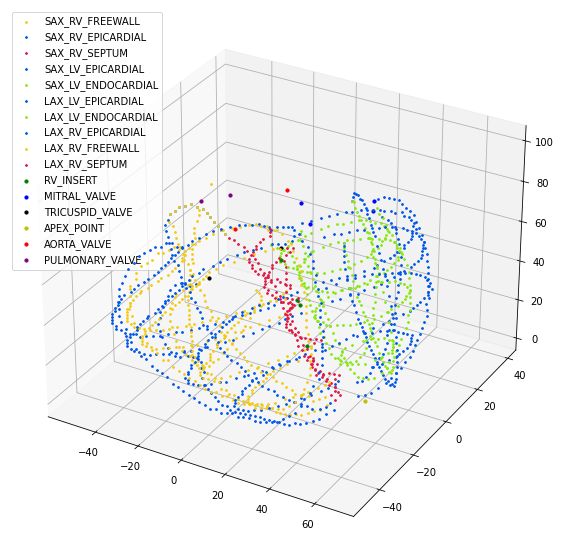

In [267]:
# Display guide point results if desired
from mpl_toolkits import mplot3d
coordinates = []
model_folder = '../data/processed/' + patient
with open(model_folder + '/GP_ES.txt', 'r') as f:
    for i,line in enumerate(f.readlines()):
        if i > 0:
            points = line.split('\t')
            coordinates.append([float(points[0]), float(points[1]), float(points[2]), points[3]])
            
len_colors = len(np.unique(np.array(coordinates)[:,3]))
from matplotlib import cm
new_map = plt.cm.get_cmap('hsv', len_colors)

# define colors for each point
map = set(np.array(coordinates)[:,3])
map_dict = {'AORTA_VALVE': 'r',
 'MITRAL_VALVE': 'b',
 'RV_INSERT': 'g',
 'APEX_POINT': 'y',
 'SAX_RV_FREEWALL': '#F2CA19',
 'LAX_LV_EPICARDIAL': '#0057E9',
 'TRICUSPID_VALVE': 'k',
 'LAX_RV_SEPTUM': '#E11845',
 'SAX_RV_SEPTUM': '#E11845',
 'LAX_RV_EPICARDIAL': '#0057E9',
 'LAX_RV_FREEWALL': '#F2CA19',
 'PULMONARY_VALVE': 'purple',
 'SAX_LV_ENDOCARDIAL': '#87E911',
 'SAX_LV_EPICARDIAL': '#0057E9',
 'SAX_RV_EPICARDIAL': '#0057E9',
 'LAX_LV_ENDOCARDIAL': '#87E911'}

%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

labels = []
for p1 in coordinates:
    lab = p1[3]
    if 'LAX' in lab or 'SAX' in lab:
        s = 3
    else:
        s = 10
        
    if lab in labels:
        ax.scatter3D(p1[0], p1[1], p1[2], color=map_dict[lab], s=s)
    else:
        labels.append(lab)
        ax.scatter3D(p1[0], p1[1], p1[2], color=map_dict[lab], label=p1[3], s=s)
plt.legend()

plt.show()

In [270]:
# move GP and slice info files to the BiV Modelling v2 module
import shutil 

root = 'E:/CAP/CAP-FullAutomation/CIM/BiV_Modelling_v2/test_data/'
if not os.path.isdir(root + patient):
    os.mkdir(os.path.join(root, patient))
    
shutil.copyfile(os.path.join(dst, patient, 'GP_ED.txt'), os.path.join(root, patient, 'GP_ED.txt'))
shutil.copyfile(os.path.join(dst, patient, 'GP_ES.txt'), os.path.join(root, patient, 'GP_ES.txt'))
shutil.copyfile(os.path.join(dst, patient, 'SliceInfo.txt'), os.path.join(root, patient, 'SliceInfo.txt'))

'E:/CAP/CAP-FullAutomation/CIM/BiV_Modelling_v2/test_data/venus1\\SliceInfo.txt'